# Realized Volatility Forecast

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Exploratory Data Analysis

In [3]:
START_DATE = "1990-01-01"
END_DATE = "2024-12-31"

spyTicker = yf.Ticker("SPY") # SPDR S&P 500 ETF Trust
vixTicker = yf.Ticker("^VIX") # VIX
df_spy = spyTicker.history(start=START_DATE, end=END_DATE)
df_vix = vixTicker.history(start=START_DATE, end=END_DATE)

In [4]:
# Remove extra rows from vix to match spy
df_vix = df_vix.drop(df_vix.loc['1990':'1993-01-28'].index)

In [5]:
# Remove Timestamps to make rows line up better across datasets
df_spy.index = df_spy.index.date
df_vix.index = df_vix.index.date

In [6]:
df_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
1993-01-29,24.330323,24.330323,24.209276,24.313030,1003200,0.0,0.0,0.0
1993-02-01,24.330319,24.485950,24.330319,24.485950,480500,0.0,0.0,0.0
1993-02-02,24.468669,24.555130,24.416792,24.537838,201300,0.0,0.0,0.0
1993-02-03,24.572420,24.814513,24.555127,24.797220,529400,0.0,0.0,0.0
1993-02-04,24.883695,24.952865,24.607018,24.900988,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-12-23,585.757434,590.129101,582.555449,589.524414,57635800,0.0,0.0,0.0
2024-12-24,590.882491,596.116657,590.297589,596.076965,33160100,0.0,0.0,0.0
2024-12-26,594.292655,597.246751,592.885006,596.116699,41219100,0.0,0.0,0.0
2024-12-27,592.349606,592.587572,585.628530,589.841614,64969300,0.0,0.0,0.0


In [7]:
df_vix

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1993-01-29,12.490000,13.160000,12.420000,12.420000,0,0.0,0.0
1993-02-01,12.510000,12.920000,12.180000,12.330000,0,0.0,0.0
1993-02-02,12.470000,12.890000,12.220000,12.250000,0,0.0,0.0
1993-02-03,11.980000,12.340000,11.790000,12.120000,0,0.0,0.0
1993-02-04,11.860000,12.840000,11.690000,12.290000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23,18.090000,20.020000,16.740000,16.780001,0,0.0,0.0
2024-12-24,16.969999,17.040001,14.270000,14.270000,0,0.0,0.0
2024-12-26,14.990000,15.930000,14.550000,14.730000,0,0.0,0.0
2024-12-27,15.380000,18.450001,15.290000,15.950000,0,0.0,0.0


In [8]:
# join datasets
dataset = pd.merge(df_spy, df_vix, left_index=True, right_index=True, suffixes=('_SPY','_VIX'))
dataset = dataset.drop(['Dividends_SPY','Stock Splits_SPY', 'Capital Gains', 'Dividends_VIX', 'Stock Splits_VIX', 'Volume_VIX'], axis=1)

# Load FFER data, make Column A the index
FFER = pd.read_csv("FFER.csv", index_col=0, parse_dates=True)

# Rename FFER column 
FFER.columns = ["FFER"]

# Merge on the index
dataset = dataset.join(FFER, how="left")

# Load US Economic Uncertainty data, make Column A the index
econ_uncert = pd.read_csv("FFER.csv", index_col=0, parse_dates=True)

# Rename US Econmic Unceratainty column 
econ_uncert.columns = ["Economic Uncertainty"]

# Merge on the index
dataset = dataset.join(econ_uncert, how="left")

print(dataset.head())
print(dataset.isna().sum())

             Open_SPY   High_SPY    Low_SPY  Close_SPY  Volume_SPY  Open_VIX  \
1993-01-29  24.330323  24.330323  24.209276  24.313030     1003200     12.49   
1993-02-01  24.330319  24.485950  24.330319  24.485950      480500     12.51   
1993-02-02  24.468669  24.555130  24.416792  24.537838      201300     12.47   
1993-02-03  24.572420  24.814513  24.555127  24.797220      529400     11.98   
1993-02-04  24.883695  24.952865  24.607018  24.900988      531500     11.86   

            High_VIX  Low_VIX  Close_VIX  FFER  Economic Uncertainty  
1993-01-29     13.16    12.42      12.42  3.02                  3.02  
1993-02-01     12.92    12.18      12.33  3.25                  3.25  
1993-02-02     12.89    12.22      12.25  3.18                  3.18  
1993-02-03     12.34    11.79      12.12  3.56                  3.56  
1993-02-04     12.84    11.69      12.29  3.08                  3.08  
Open_SPY                0
High_SPY                0
Low_SPY                 0
Close_SPY      

In [9]:
# Download 3M T-Bill yield
tbill = yf.Ticker("^IRX")
df_tbill = tbill.history(period="max")

# Align date index
df_tbill.index = df_tbill.index.date
df_tbill = df_tbill[['Close']] # Take yield

# Rename column
df_tbill.columns = ['TBill_3M']

# Merge with your main dataset
dataset = dataset.join(df_tbill, how="left")

In [10]:
dataset

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,FFER,Economic Uncertainty,TBill_3M
1993-01-29,24.330323,24.330323,24.209276,24.313030,1003200,12.490000,13.160000,12.420000,12.420000,3.02,3.02,2.900
1993-02-01,24.330319,24.485950,24.330319,24.485950,480500,12.510000,12.920000,12.180000,12.330000,3.25,3.25,2.900
1993-02-02,24.468669,24.555130,24.416792,24.537838,201300,12.470000,12.890000,12.220000,12.250000,3.18,3.18,2.960
1993-02-03,24.572420,24.814513,24.555127,24.797220,529400,11.980000,12.340000,11.790000,12.120000,3.56,3.56,2.930
1993-02-04,24.883695,24.952865,24.607018,24.900988,531500,11.860000,12.840000,11.690000,12.290000,3.08,3.08,2.900
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,585.757434,590.129101,582.555449,589.524414,57635800,18.090000,20.020000,16.740000,16.780001,4.33,4.33,4.215
2024-12-24,590.882491,596.116657,590.297589,596.076965,33160100,16.969999,17.040001,14.270000,14.270000,4.33,4.33,4.200
2024-12-26,594.292655,597.246751,592.885006,596.116699,41219100,14.990000,15.930000,14.550000,14.730000,4.33,4.33,4.215
2024-12-27,592.349606,592.587572,585.628530,589.841614,64969300,15.380000,18.450001,15.290000,15.950000,4.33,4.33,4.178


In [11]:
# SPY features
# daily log price and  natural log-returns for SPY
dataset["log_close_SPY"] = np.log(dataset["Close_SPY"])
dataset["log_open_SPY"] = np.log(dataset["Open_SPY"])
dataset["ret_1d"] = dataset["log_close_SPY"].diff(1)   # daily natural log-return

# intraday turbulance
dataset["intraday_OC_abs"] = np.abs(dataset["log_open_SPY"] - dataset["log_close_SPY"])
dataset["intraday_OC"] = dataset["log_open_SPY"] - dataset["log_close_SPY"]
dataset["intraday_CO_abs"] = np.abs(dataset["log_close_SPY"].shift(1) - dataset["log_open_SPY"]) #What happend overnight? price jumped/Crashed? 
dataset["intraday_CH"] = dataset["log_close_SPY"].shift(1) - np.log(dataset["High_SPY"])
dataset["intraday_CL"] = dataset["log_close_SPY"].shift(1) - np.log(dataset["Low_SPY"])
dataset["intraday_CO"] = dataset["log_close_SPY"].shift(1) - dataset["log_open_SPY"]
dataset["intraday_HL"] = np.log(dataset["High_SPY"]) - np.log(dataset["Low_SPY"])
dataset["intraday_HL_abs"] = np.abs(np.log(dataset["High_SPY"]) - np.log(dataset["Low_SPY"]))

# lagged returns (1 and 2 days)
dataset["ret_lag1"] = dataset["ret_1d"].shift(1)
dataset["ret_lag2"] = dataset["ret_1d"].shift(2)
dataset["intraday_HL_abs_lag1"] = dataset["intraday_HL_abs"].shift(1)
dataset["intraday_HL_abs_lag2"] = dataset["intraday_HL_abs"].shift(2)
dataset["intraday_HL_lag1"] = dataset["intraday_HL"].shift(1)
dataset["intraday_HL_lag2"] = dataset["intraday_HL"].shift(2)

# rolling statistics of returns
dataset["ret_roll_mean_5d"] = dataset["ret_1d"].rolling(5, min_periods=1).mean()
dataset["ret_roll_std_5d"] = dataset["ret_1d"].rolling(5, min_periods=1).std()
dataset["ret_roll_abs_5d"] = np.abs(dataset["ret_1d"].rolling(5, min_periods=1).sum())

dataset["ret_roll_mean_22d"] = dataset["ret_1d"].rolling(22, min_periods=1).mean()
dataset["ret_roll_std_22d"] = dataset["ret_1d"].rolling(22, min_periods=1).std()
dataset["ret_roll_abs_22d"] = np.abs(dataset["ret_1d"].rolling(22, min_periods=1).sum())

dataset["intraday_roll_CO_mean_5d"] = dataset["intraday_CO"].rolling(5, min_periods=1).mean()
dataset["intraday_roll_CO_std_5d"] = dataset["intraday_CO"].rolling(5,min_periods=1).std()
dataset["intraday_roll_CO_mean_22d"] = dataset["intraday_CO"].rolling(22,min_periods=1).mean()
dataset["intraday_roll_CO_std_22d"] = dataset["intraday_CO"].rolling(22,min_periods=1).std()

# Technical indicators: moving averages on Close (5, 10, 22 days)
dataset["ma_5"] = dataset["log_close_SPY"].rolling(window=5, min_periods=1).mean()
dataset["ma_10"] = dataset["log_close_SPY"].rolling(window=10,min_periods=1).mean()
dataset["ma_22"] = dataset["log_close_SPY"].rolling(window=22,min_periods=1).mean()

dataset["momentum_5d"] = dataset["log_close_SPY"] - dataset["log_close_SPY"].shift(5)
dataset["momentum_22d"] = dataset["log_close_SPY"] - dataset["log_close_SPY"].shift(22)

#Relative Strength Index. Measure between 0 - 100 indicating if more gains or loss has occured in predefined time period
delta = dataset["ret_1d"]

gain = delta.clip(lower=0)  
loss = -delta.clip(upper=0) 

avg_gain = gain.rolling(5, min_periods=1).mean()
avg_loss = loss.rolling(5, min_periods=1).mean()

# Avoid divide-by-zero
avg_loss = avg_loss.replace(0, 1e-10)

RS = avg_gain / avg_loss
RSI = 100 - (100 / (1 + RS))

dataset["RSI_5d"] = RSI

# Bollinger Bands. Measure how close or far is the current price from the moving average of a predefine time period
dataset["BB_low"] = dataset["ma_22"] - (2 * dataset["log_close_SPY"].rolling(22).std())
dataset["BB_high"] = dataset["ma_22"] + (2 * dataset["log_close_SPY"].rolling(22).std())

dataset["BB_percentage_diff"] =  (dataset["BB_high"] - dataset["BB_low"]) / dataset["ma_22"]
dataset["BB_price_location"] =  (dataset["log_close_SPY"] - dataset["BB_low"]) / (dataset["BB_high"] - dataset["BB_low"] + 1e-10)

#Average True Range. Pick the largets movement between H/L, Ct-1/H, Ct-1/L
dataset["TR"] = dataset[["intraday_HL","intraday_CH", "intraday_CL"]].max(axis=1)
dataset["ATR"] = dataset["TR"].rolling(14, min_periods=1).mean()

# Rate of change (ROC) – 5 and 10 day
dataset["roc_5"] = dataset["Close_SPY"].pct_change(periods=5)
dataset["roc_10"] = dataset["Close_SPY"].pct_change(periods=10)

# Volume-related feature (log-volume + 10-day rolling mean)
dataset["log_volume"] = np.log(dataset["Volume_SPY"].replace(0, np.nan))
dataset["vol_roll_mean_10"] = dataset["log_volume"].rolling(window=10,min_periods=1).mean()

# Realized variance and lagged relalized variance daily, weekly, monthly
dataset["rvar_1d"] = dataset["ret_1d"] ** 2
dataset["rvar_5d"] = dataset["rvar_1d"].rolling(window=5,min_periods=1).sum()
dataset["rvar_22d"] = dataset["rvar_1d"].rolling(window=22,min_periods=1).sum()

# Realized volatility and lagged relalized volatility daily, weekly, monthly
dataset["rvol_1d"] = np.sqrt(dataset["rvar_1d"]) # Y lable
dataset["rvol_5d"] = np.sqrt(dataset["rvar_5d"])
dataset["rvol_22d"] = np.sqrt(dataset["rvar_22d"])

In [12]:
dataset = dataset.dropna()

In [13]:
dataset

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,FFER,...,roc_5,roc_10,log_volume,vol_roll_mean_10,rvar_1d,rvar_5d,rvar_22d,rvol_1d,rvol_5d,rvol_22d
1993-03-03,24.900984,24.987446,24.866400,24.970154,280100,13.140000,13.710000,12.930000,13.130000,3.29,...,0.019775,0.038849,12.542902,11.702639,1.733961e-05,0.000248,0.001409,0.004164,0.015753,0.037530
1993-03-04,25.004730,25.004730,24.831806,24.831806,89500,12.520000,14.020000,12.500000,13.440000,3.10,...,0.011980,0.033837,11.401994,11.558547,3.086830e-05,0.000275,0.001389,0.005556,0.016570,0.037271
1993-03-05,24.866385,24.970139,24.745338,24.762630,40000,13.200000,14.130000,12.980000,14.080000,3.02,...,0.007741,0.027259,10.596635,11.572186,7.782193e-06,0.000280,0.001392,0.002790,0.016744,0.037316
1993-03-08,24.814524,25.316002,24.814524,25.316002,50800,15.000000,16.299999,14.950000,16.219999,3.06,...,0.033169,0.046462,10.835652,11.340831,4.884542e-04,0.000761,0.001770,0.022101,0.027584,0.042075
1993-03-09,25.264119,25.281411,25.177657,25.229534,169300,14.020000,15.430000,13.780000,14.170000,2.98,...,0.014604,0.043634,12.039428,11.261653,1.170586e-05,0.000556,0.001765,0.003421,0.023583,0.042007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,585.757434,590.129101,582.555449,589.524414,57635800,18.090000,20.020000,16.740000,16.780001,4.33,...,-0.016642,-0.013211,17.869654,17.798526,3.564704e-05,0.001111,0.001424,0.005971,0.033329,0.037733
2024-12-24,590.882491,596.116657,590.297589,596.076965,33160100,16.969999,17.040001,14.270000,14.270000,4.33,...,-0.001599,0.000869,17.316858,17.786937,1.221834e-04,0.001216,0.001517,0.011054,0.034870,0.038952
2024-12-26,594.292655,597.246751,592.885006,596.116699,41219100,14.990000,15.930000,14.550000,14.730000,4.33,...,0.029140,-0.006743,17.534412,17.823215,4.443124e-09,0.000300,0.001508,0.000067,0.017334,0.038829
2024-12-27,592.349606,592.587572,585.628530,589.841614,64969300,15.380000,18.450001,15.290000,15.950000,4.33,...,0.018619,-0.012108,17.989425,17.895469,1.119872e-04,0.000412,0.001608,0.010582,0.020307,0.040103


# Preprocessing

In [14]:
X = dataset
y = dataset["rvol_1d"].shift(-1)

print("shape of x:", X.shape)
print("shape of y:", y.tail())
X = X.iloc[:-1]
y = y.iloc[:-1]

shape of x: (7994, 61)
shape of y: 2024-12-23    0.011054
2024-12-24    0.000067
2024-12-26    0.010582
2024-12-27    0.011477
2024-12-30         NaN
Name: rvol_1d, dtype: float64


In [15]:
print("shape of x:", X.shape)
print("shape of y:", y.shape)
print("last 5 rows of y:", y.tail())

shape of x: (7993, 61)
shape of y: (7993,)
last 5 rows of y: 2024-12-20    0.005971
2024-12-23    0.011054
2024-12-24    0.000067
2024-12-26    0.010582
2024-12-27    0.011477
Name: rvol_1d, dtype: float64


In [ ]:
# Split data between train, validate, test (70, 15, 15)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

In [17]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((5595, 61), (1199, 61), (1199, 61), (5595,), (1199,), (1199,))

# Random Forest Model

In [18]:
# Initialize model
rf = RandomForestRegressor(
    n_estimators=200, 
    max_depth=4,    
    random_state=RANDOM_STATE
)

# Fit on training data
rf.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)
y_val_pred_rf = rf.predict(X_val)

# Training metrics 
train_mse_rf  = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = train_mse_rf ** 0.5
train_mae_rf  = mean_absolute_error(y_train, y_train_pred_rf)
train_r2_rf   = r2_score(y_train, y_train_pred_rf)

# Validation metrics
val_mse_rf  = mean_squared_error(y_val, y_val_pred_rf)
val_rmse_rf = val_mse_rf ** 0.5
val_mae_rf  = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf   = r2_score(y_val, y_val_pred_rf)

# Testing metrics
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_rmse_rf = test_mse_rf**0.5
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = rf.score(X_test, y_test)

# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_rf)
print("MAE  (train):", train_mae_rf)
print("R^2  (train):", train_r2_rf)

# Print comparison 
print("\nValidation Metrics")
print("RMSE (val):", val_rmse_rf)
print("MAE  (val):", val_mae_rf)
print("R^2  (val):", val_r2_rf)

print("\nTest Metrics")
print("RMSE (test):", test_rmse_rf)
print("MAE  (test):", test_mae_rf)
print("R^2  (test): ", test_r2_rf)

Training Metrics
RMSE (train): 0.006829462719365056
MAE  (train): 0.004859948188113222
R^2  (train): 0.4023737479964846

Validation Metrics
RMSE (val): 0.0073051065303357185
MAE  (val): 0.004380162906159222
R^2  (val): 0.37231200154139465

Test Metrics
RMSE (test): 0.006808146139635399
MAE  (test): 0.004984151130907331
R^2  (test):  0.22924434146243333


## Most Representative Features

In [19]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(fi)

                 feature  importance
6               High_VIX    0.320438
8              Close_VIX    0.100091
5               Open_VIX    0.096305
52                roc_10    0.076180
50                   ATR    0.052524
..                   ...         ...
45                BB_low    0.000657
2                Low_SPY    0.000570
10  Economic Uncertainty    0.000484
9                   FFER    0.000427
0               Open_SPY    0.000264

[61 rows x 2 columns]


# Linear Regression 

In [20]:
# Standardize data with 0 mean and variance
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_val_std = std.transform(X_val)
X_test_std = std.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_std, y_train)

# Predictions
y_train_pred_lr = lr.predict(X_train_std)
y_test_pred_lr  = lr.predict(X_test_std)
y_val_pred_lr   = lr.predict(X_val_std)

# Training metrics 
train_mse_lr  = mean_squared_error(y_train, y_train_pred_lr)
train_rmse_lr = train_mse_lr ** 0.5
train_mae_lr  = mean_absolute_error(y_train, y_train_pred_lr)
train_r2_lr   = r2_score(y_train, y_train_pred_lr)

# Validation metrics
val_mse_lr  = mean_squared_error(y_val, y_val_pred_lr)
val_rmse_lr = val_mse_lr ** 0.5
val_mae_lr  = mean_absolute_error(y_val, y_val_pred_lr)
val_r2_lr   = r2_score(y_val, y_val_pred_lr)

# Test metrics
test_mse_lr  = mean_squared_error(y_test, y_test_pred_lr)
test_rmse_lr = test_mse_lr ** 0.5
test_mae_lr  = mean_absolute_error(y_test, y_test_pred_lr)
test_r2_lr  = r2_score(y_test, y_test_pred_lr)

# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_lr)
print("MAE  (train):", train_mae_lr)
print("R^2  (train):", train_r2_lr)

print("\nValidation Metrics")
print("RMSE (val):", val_rmse_lr)
print("MAE  (val):", val_mae_lr)
print("R^2  (val):", val_r2_lr)

print("\nTest Metrics")
print("RMSE (test):", test_rmse_lr)
print("MAE  (test):", test_mae_lr)
print("R^2  (test):", test_r2_lr)

Training Metrics
RMSE (train): 0.00711019592679398
MAE  (train): 0.004945038315685408
R^2  (train): 0.3522316483360123

Validation Metrics
RMSE (val): 0.0072853958372095795
MAE  (val): 0.00426917788107148
R^2  (val): 0.3756946966822424

Test Metrics
RMSE (test): 0.008355133606616046
MAE  (test): 0.006039043369916452
R^2  (test): -0.1608224027529408


## Most Representative Features

In [21]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lr.coef_
}).sort_values("importance", key=lambda x: x.abs(), ascending=False)

print(fi)

            feature  importance
51            roc_5    0.065573
0          Open_SPY   -0.045128
46          BB_high   -0.039462
45           BB_low    0.036672
42      momentum_5d   -0.033211
..              ...         ...
17  intraday_CO_abs    0.000061
15  intraday_OC_abs    0.000059
57         rvar_22d   -0.000041
24         ret_lag2   -0.000017
23         ret_lag1   -0.000017

[61 rows x 2 columns]


# XGBoost

In [22]:
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.5,
    reg_lambda=2,
    min_child_weight=5,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
)

# Fit on training data
xgb.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb  = xgb.predict(X_test)
y_val_pred_xgb = xgb.predict(X_val)

# Training metrics 
train_mse_xgb  = mean_squared_error(y_train, y_train_pred_xgb)
train_rmse_xgb = train_mse_xgb ** 0.5
train_mae_xgb  = mean_absolute_error(y_train, y_train_pred_xgb)
train_r2_xgb   = r2_score(y_train, y_train_pred_xgb)

# Validation metrics
val_mse_xgb  = mean_squared_error(y_val, y_val_pred_xgb)
val_rmse_xgb = val_mse_lr ** 0.5
val_mae_xgb  = mean_absolute_error(y_val, y_val_pred_xgb)
val_r2_xgb   = r2_score(y_val, y_val_pred_xgb)

# Test metrics
test_mse_xgb  = mean_squared_error(y_test, y_test_pred_xgb)
test_rmse_xgb = test_mse_xgb ** 0.5
test_mae_xgb  = mean_absolute_error(y_test, y_test_pred_xgb)
test_r2_xgb   = r2_score(y_test, y_test_pred_xgb)

# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_xgb)
print("MAE  (train):", train_mae_xgb)
print("R^2  (train):", train_r2_xgb)

print("\nValidation Metrics")
print("RMSE (val):", val_rmse_xgb)
print("MAE  (val):", val_mae_xgb)
print("R^2  (val):", val_r2_xgb)

print("\nTest Metrics")
print("RMSE (test):", test_rmse_xgb)
print("MAE  (test):", test_mae_xgb)
print("R^2  (test):", test_r2_xgb)

Training Metrics
RMSE (train): 0.006649479093353936
MAE  (train): 0.004605249000084543
R^2  (train): 0.4334583552665383

Validation Metrics
RMSE (val): 0.0072853958372095795
MAE  (val): 0.0044440039262080315
R^2  (val): 0.33771316955636854

Test Metrics
RMSE (test): 0.0067814205602011466
MAE  (test): 0.0048412086005954315
R^2  (test): 0.2352837126437558


## Most Representative Features

In [23]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values("importance", ascending=False)

print(fi)

                      feature  importance
6                    High_VIX    0.167498
7                     Low_VIX    0.158974
5                    Open_VIX    0.089869
50                        ATR    0.087441
8                   Close_VIX    0.041412
..                        ...         ...
46                    BB_high    0.003230
35   intraday_roll_CO_mean_5d    0.003128
37  intraday_roll_CO_mean_22d    0.003123
11                   TBill_3M    0.003074
53                 log_volume    0.002021

[61 rows x 2 columns]


# LSTM

In [24]:
feature_cols_lstm = [
    "ret_1d", "intraday_OC", "intraday_CO", "intraday_HL",
    "rvol_5d", "rvol_22d",              # keep past vol, drop rvol_1d from features
    "Close_VIX", "High_VIX", "Low_VIX",
    "FFER", "TBill_3M"
]

label_col = "rvol_1d"

data_lstm = dataset[feature_cols_lstm + [label_col]].dropna().copy()

# next-day label
data_lstm["rv_next"] = data_lstm[label_col].shift(-1)
data_lstm = data_lstm.dropna()

data_lstm.shape

(7993, 13)

In [25]:
n = len(data_lstm)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_df = data_lstm.iloc[:train_end]
val_df   = data_lstm.iloc[train_end:val_end]
test_df  = data_lstm.iloc[val_end:]

scaler = StandardScaler()
scaler.fit(train_df[feature_cols_lstm])

train_feats = scaler.transform(train_df[feature_cols_lstm])
val_feats   = scaler.transform(val_df[feature_cols_lstm])
test_feats  = scaler.transform(test_df[feature_cols_lstm])

train_targets = train_df["rv_next"].values
val_targets   = val_df["rv_next"].values
test_targets  = test_df["rv_next"].values

In [26]:
seq_len = 30

def make_sequences(features_2d, targets_1d, seq_len):
    X, y = [], []
    for i in range(len(features_2d) - seq_len):
        X.append(features_2d[i:i+seq_len])
        y.append(targets_1d[i+seq_len-1])
    return np.array(X), np.array(y)
 
X_train_lstm, y_train_lstm = make_sequences(train_feats, train_targets, seq_len)
X_val_lstm,   y_val_lstm   = make_sequences(val_feats, val_targets, seq_len)
X_test_lstm,  y_test_lstm  = make_sequences(test_feats, test_targets, seq_len)

In [27]:
class VolDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(VolDataset(X_train_lstm, y_train_lstm), batch_size=64, shuffle=True)
val_loader   = DataLoader(VolDataset(X_val_lstm,   y_val_lstm),   batch_size=64, shuffle=False)
test_loader  = DataLoader(VolDataset(X_test_lstm,  y_test_lstm),  batch_size=64, shuffle=False)

In [28]:
input_dim = len(feature_cols_lstm)
hidden_dim = 64

class LSTMVolPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.act = nn.ReLU()
        self.out = nn.Linear(32, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        h_last = lstm_out[:, -1, :] # last hidden state
        x = self.fc1(h_last)
        x = self.act(x)
        return self.out(x)

model = LSTMVolPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [29]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(Xb)
        
    train_loss /= len(train_loader.dataset)
    
    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            preds = model(Xb).squeeze()
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(Xb)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}  Train MSE={train_loss:.6f}  Val MSE={val_loss:.6f}")

Epoch 1/25  Train MSE=0.001670  Val MSE=0.000057
Epoch 2/25  Train MSE=0.000063  Val MSE=0.000060
Epoch 3/25  Train MSE=0.000058  Val MSE=0.000067
Epoch 4/25  Train MSE=0.000059  Val MSE=0.000060
Epoch 5/25  Train MSE=0.000057  Val MSE=0.000063
Epoch 6/25  Train MSE=0.000056  Val MSE=0.000067
Epoch 7/25  Train MSE=0.000053  Val MSE=0.000051
Epoch 8/25  Train MSE=0.000054  Val MSE=0.000054
Epoch 9/25  Train MSE=0.000054  Val MSE=0.000062
Epoch 10/25  Train MSE=0.000055  Val MSE=0.000057
Epoch 11/25  Train MSE=0.000053  Val MSE=0.000064
Epoch 12/25  Train MSE=0.000052  Val MSE=0.000064
Epoch 13/25  Train MSE=0.000054  Val MSE=0.000069
Epoch 14/25  Train MSE=0.000052  Val MSE=0.000060
Epoch 15/25  Train MSE=0.000050  Val MSE=0.000066
Epoch 16/25  Train MSE=0.000050  Val MSE=0.000069
Epoch 17/25  Train MSE=0.000050  Val MSE=0.000066
Epoch 18/25  Train MSE=0.000050  Val MSE=0.000065
Epoch 19/25  Train MSE=0.000050  Val MSE=0.000075
Epoch 20/25  Train MSE=0.000049  Val MSE=0.000064
Epoch 21/

In [30]:
model.eval()
all_preds = []

with torch.no_grad():
    for Xb, _ in test_loader:
        preds = model(Xb).squeeze()
        all_preds.extend(preds.numpy())

y_test_pred_lstm = np.array(all_preds)

test_mse_lstm  = mean_squared_error(y_test_lstm, y_test_pred_lstm)
test_rmse_lstm = np.sqrt(test_mse_lstm)
test_mae_lstm  = mean_absolute_error(y_test_lstm, y_test_pred_lstm)
test_r2_lstm   = r2_score(y_test_lstm, y_test_pred_lstm)

print(f"LSTM Test RMSE: {test_rmse_lstm:.6f}")
print(f"LSTM Test MAE : {test_mae_lstm:.6f}")
print(f"LSTM Test R²  : {test_r2_lstm:.4f}")

LSTM Test RMSE: 0.007110
LSTM Test MAE : 0.005244
LSTM Test R²  : 0.0197


In [31]:
model.eval()
val_preds = []

with torch.no_grad():
    for Xb, _ in val_loader:
        preds = model(Xb).squeeze()
        val_preds.extend(preds.numpy())

y_val_pred_lstm = np.array(val_preds)

val_mse_lstm  = mean_squared_error(y_val_lstm, y_val_pred_lstm)
val_rmse_lstm = np.sqrt(val_mse_lstm)
val_mae_lstm  = mean_absolute_error(y_val_lstm, y_val_pred_lstm)
val_r2_lstm   = r2_score(y_val_lstm, y_val_pred_lstm)

print("Validation Metrics")
print(f"LSTM Val RMSE: {val_rmse_lstm:.6f}")
print(f"LSTM Val MAE : {val_mae_lstm:.6f}")
print(f"LSTM Val R²  : {val_r2_lstm:.4f}")

Validation Metrics
LSTM Val RMSE: 0.008450
LSTM Val MAE : 0.004866
LSTM Val R²  : 0.1743


In [32]:
def rnn_predict(model, X):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), 64):  # batch size 64
            Xb = torch.tensor(X[i:i+64], dtype=torch.float32)
            out = model(Xb).cpu().numpy().flatten()
            preds.extend(out)
    return np.array(preds)

baseline_pred = rnn_predict(model, X_test_lstm)
baseline_rmse = np.sqrt(mean_squared_error(y_test_lstm, baseline_pred))
baseline_rmse

feature_names = feature_cols_lstm # same order as input_dim

importances = []

for f in range(X_test_lstm.shape[2]): # loop over features
    X_test_permuted = X_test_lstm.copy()
    np.random.shuffle(X_test_permuted[:, :, f]) # shuffle this feature across sequences
    
    perm_pred = rnn_predict(model, X_test_permuted)
    perm_rmse = np.sqrt(mean_squared_error(y_test_lstm, perm_pred))
    
    importance = perm_rmse - baseline_rmse # increase in error
    importances.append(importance)

fi_rnn = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_rnn

,feature,importance
9,FFER,0.001388
6,Close_VIX,0.001126
10,TBill_3M,0.001040
7,High_VIX,0.001014
3,intraday_HL,0.000851
8,Low_VIX,0.000353
0,ret_1d,0.000124
4,rvol_5d,0.000122
2,intraday_CO,0.000107
5,rvol_22d,-0.000043


# Metrics

In [33]:
cols_names = ['RMSE', 'MAE', 'R^2']
index_names = ['Random Forest', 'Linear Regression', 'XGB', 'LSTM']

metrics = pd.DataFrame(index=index_names, columns=cols_names)
metrics.loc['Random Forest'] = [test_rmse_rf, test_mae_rf, test_r2_rf]
metrics.loc['Linear Regression'] = [test_rmse_lr, test_mae_lr, test_r2_lr]
metrics.loc['XGB'] = [test_rmse_xgb, test_mae_xgb, test_r2_xgb]
metrics.loc['LSTM'] = [test_rmse_lstm, test_mae_lstm, test_r2_lstm]
metrics

,RMSE,MAE,R^2
Random Forest,0.006808,0.004984,0.229244
Linear Regression,0.008355,0.006039,-0.160822
XGB,0.006781,0.004841,0.235284
LSTM,0.00711,0.005244,0.019709


# Visualizations

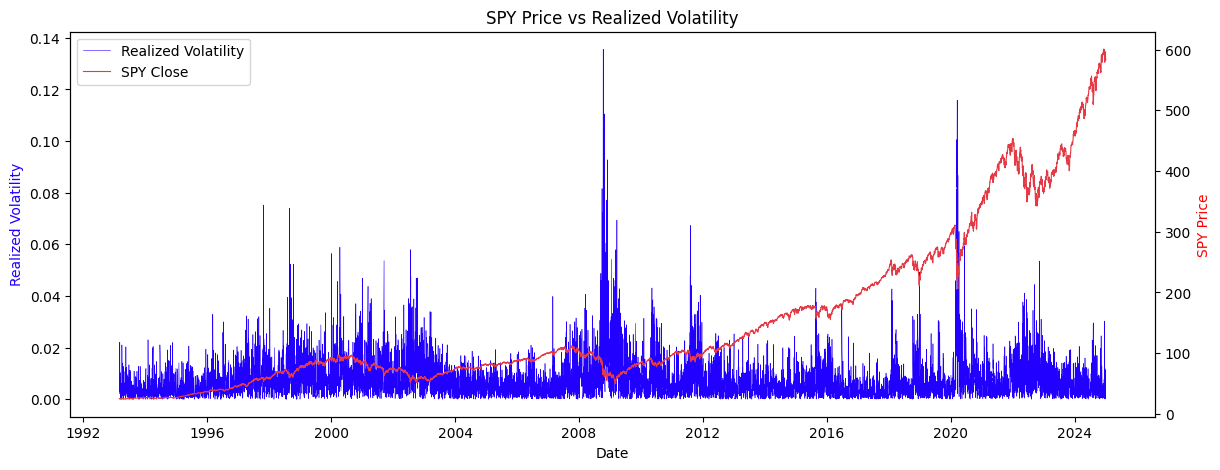

In [34]:
COLORS = {
    "actual": "#2200FF",  # blue
    "pred":   "#E63946",  # red
}

fig, ax1 = plt.subplots(figsize=(14,5))

# plot realized volatility
line1, = ax1.plot(
    dataset.index, 
    dataset["rvol_1d"], 
    color=COLORS["actual"], 
    label="Realized Volatility",
    linewidth=0.4
)
ax1.set_ylabel("Realized Volatility", color=COLORS["actual"])
ax1.set_xlabel("Date")

# twin axis for SPY
ax2 = ax1.twinx()
line2, = ax2.plot(
    dataset.index, 
    dataset["Close_SPY"], 
    color=COLORS["pred"], 
    label="SPY Close",
    linewidth=0.8
)
ax2.set_ylabel("SPY Price", color="red")
ax2.set_xlabel("Date")

# combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("SPY Price vs Realized Volatility")
plt.show()

In [35]:
seq_len = 30  # your window length

test_index = X_test.index

results = pd.DataFrame({
    "Actual RV": y_test,
    "RF Prediction": y_test_pred_rf,
    "LR Prediction": y_test_pred_lr,
    "XGB Prediction": y_test_pred_xgb
}, index=test_index)

y_lstm = np.asarray(y_test_pred_lstm).reshape(-1)  # flatten

lstm_index = test_index[-len(y_lstm):]  # take the LAST 1169 dates

# initialize column with NaN
results["LSTM Prediction"] = np.nan

# assign only where we have LSTM predictions
results.loc[lstm_index, "LSTM Prediction"] = y_lstm

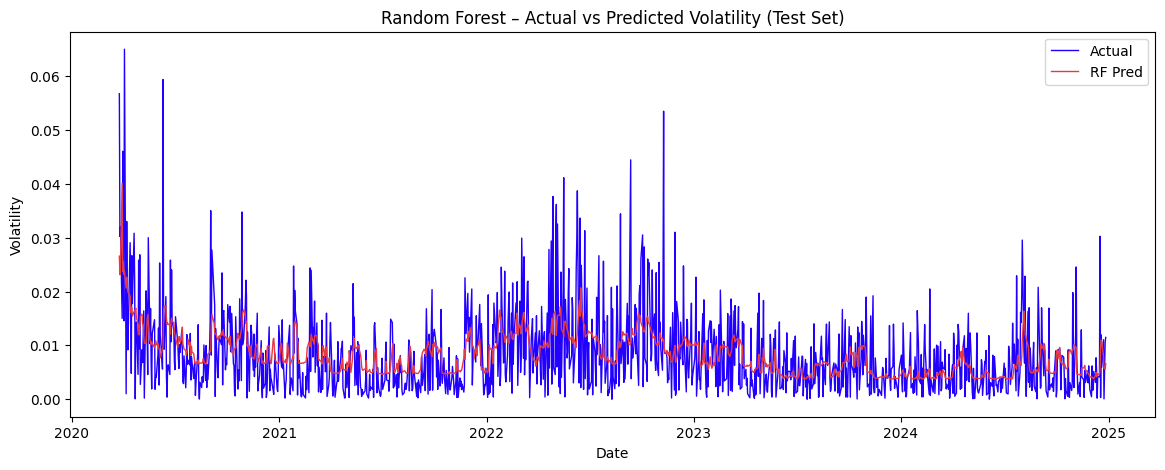

In [36]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["RF Prediction"], color=COLORS["pred"], label="RF Pred", linewidth=1)
plt.title("Random Forest – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

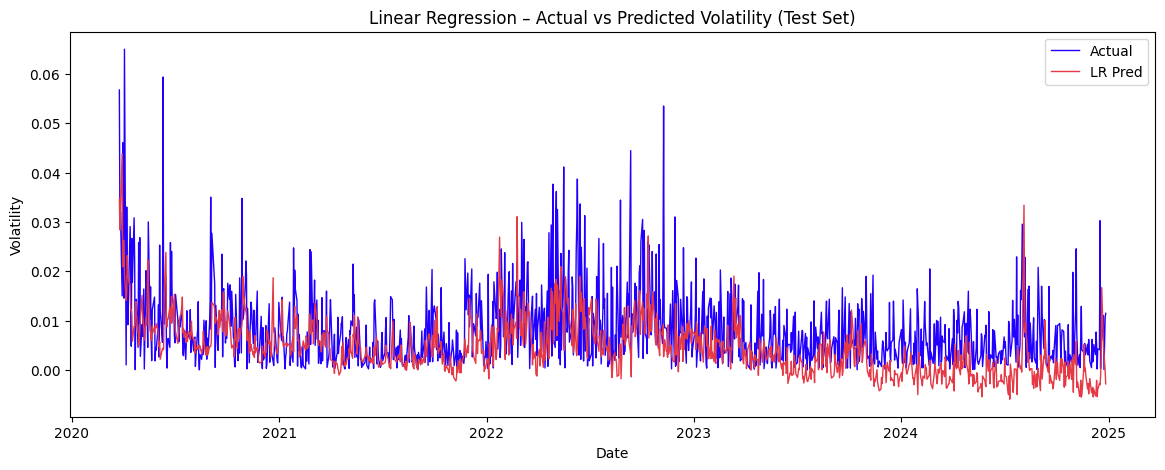

In [37]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["LR Prediction"], color=COLORS["pred"], label="LR Pred", linewidth=1)
plt.title("Linear Regression – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

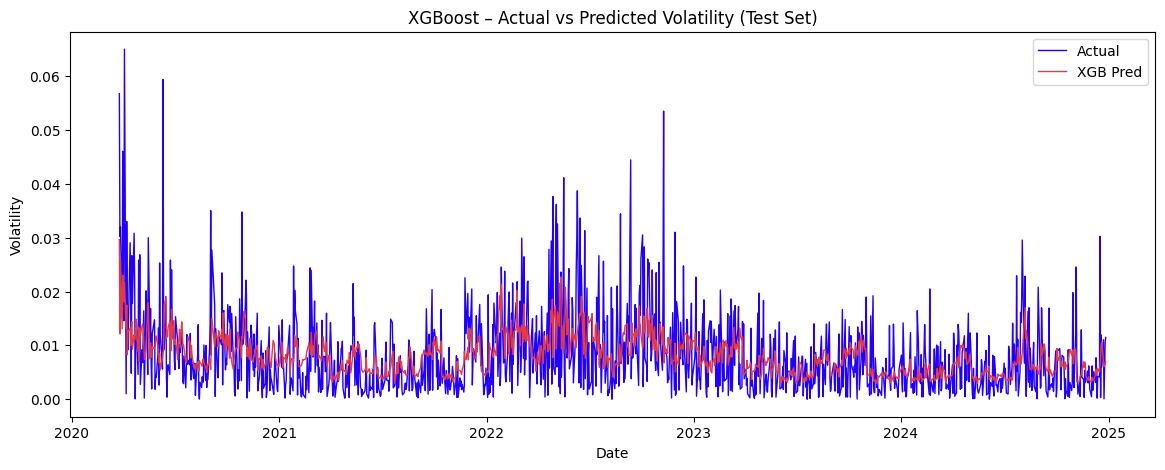

In [38]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["XGB Prediction"], color=COLORS["pred"], label="XGB Pred", linewidth=1)
plt.title("XGBoost – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

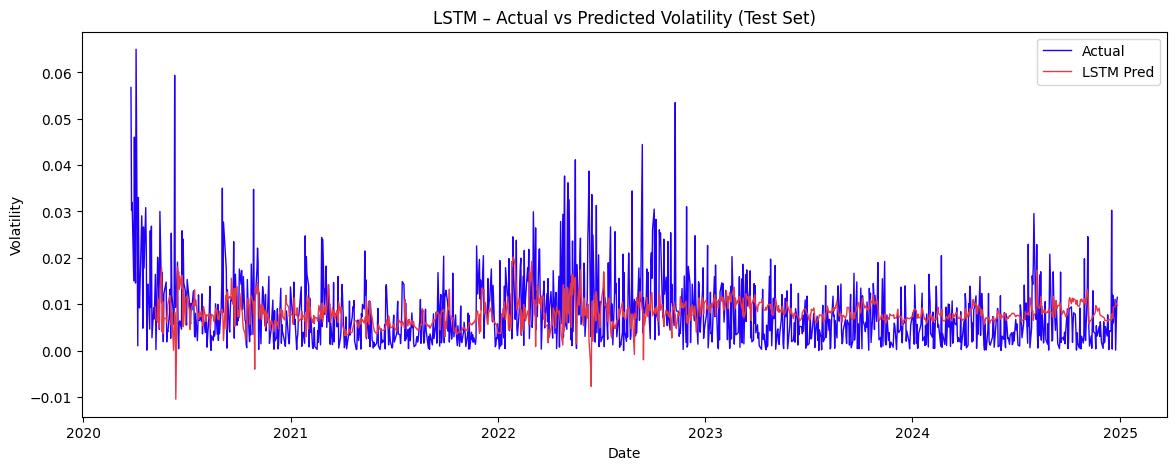

In [39]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["LSTM Prediction"], color=COLORS["pred"], label="LSTM Pred", linewidth=1)
plt.title("LSTM – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()